# Jupyter Notebook for RNA Seq Analysis.
### Author - Muthukumaraswami Sivaswami (1833616)



This analysis was done on a local machine running Python 3.11.8. Please ensure that you have the right version of Python installed on your machine, so that all the required libraries are installed and can be imported.

First, let's take a look at log2FPKM.tsv. This file contains Normalized FPKM/transcript per million (TPM) values in log2 scale. This will be our main expression data file for analysis.

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#importing the log2FPKM.tsv file, containing the RNA Seq data
log2FPKM_df = pd.read_csv('log2FPKM.tsv', sep='\t').rename({'00gene_id':'gene_id'},axis=1)

Now, let's run some sanity checks and look at the data.

In [3]:
#checking the shape of the data
print(f'log2FPKM_df shape: {log2FPKM_df.shape}') 

log2FPKM_df shape: (23146, 499)


We can see that our data has 23146 rows and 499 columns. Let's take a look at the first 5 rows of the data.

In [4]:
#checking the first few rows
log2FPKM_df.head()

,gene_id,NB001,NB002,NB003,NB004,NB005,NB006,NB007,NB008,NB009,...,NB489,NB490,NB491,NB492,NB493,NB494,NB495,NB496,NB497,NB498
0,1/2-SBSRNA4,0.834381,0.743094,0.909414,0.795775,0.905540,0.869154,1.811352,0.599240,0.981855,...,0.997977,1.003559,0.842437,1.057873,0.805515,0.491331,0.868249,0.911379,0.660139,1.152988
1,A1BG,1.910053,0.941996,1.950857,1.989477,1.942946,1.927608,1.617745,2.161291,1.436439,...,2.336929,2.836360,1.205317,2.439868,1.649027,1.451425,1.493852,1.641241,1.994978,1.289534
2,A1BG-AS1,1.453191,0.640614,1.156765,1.525277,1.365043,0.899212,1.304178,1.189205,0.771248,...,1.182908,1.367371,0.643751,1.096815,0.925425,0.933275,1.208723,0.904511,1.529221,1.102866
3,A1CF,0.005102,0.005902,0.005192,0.000000,0.025347,0.005682,0.000000,0.000000,0.021880,...,0.024298,0.007295,0.000000,0.006678,0.005746,0.004998,0.004853,0.000000,0.022780,0.018720
4,A2LD1,0.580151,0.738233,0.927667,0.936497,0.924853,0.739038,1.018705,0.546324,0.666877,...,0.673627,1.401265,0.837443,0.939849,0.743496,0.957837,0.812093,0.488748,1.068072,0.782887


This shows that the first column is simply sample IDs. It is not relevant for our analysis, so we will ignore it, for now.

Now, let's inspect the data by info.

In [5]:
log2FPKM_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23146 entries, 0 to 23145
Columns: 499 entries, gene_id to NB498
dtypes: float64(498), object(1)
memory usage: 88.1+ MB


In [6]:
#checking for missing values
log2FPKM_df.isnull().sum()

gene_id    0
NB001      0
NB002      0
NB003      0
NB004      0
          ..
NB494      0
NB495      0
NB496      0
NB497      0
NB498      0
Length: 499, dtype: int64

Our data has no missing values, which is great for a more robust downstream analysis.

Let's now do a little exploration of the data. We can start by looking at a correlation matrix.

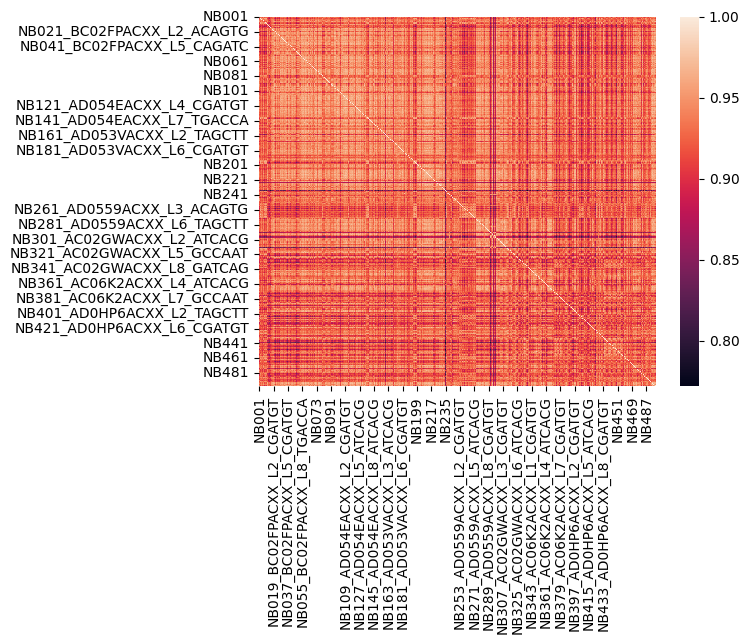

In [7]:
# Set index  
log2FPKM_df.set_index('gene_id', inplace=True)

# Calculate correlation directly
corr = log2FPKM_df.corr() 

# Heatmap  
sns.heatmap(corr)
plt.savefig('corr_heatmap.png')

The correlation values across most gene pairs appear normally distributed around 0 as expected, with no widespread strong correlations. This indicates good variability in the data.

Highly correlated genes are not obvious, which could signify technical artifacts like batch effects from sequencing or sample handling. The correlations appear randomly distributed and mixed.

Overall the heatmap provides confidence that the data is clean and ready for further analysis.

Next, let's just plot the data to see if there are any outliers.
I'll be using tSNE, which is particularly useful in visualizing data with high dimensionality.

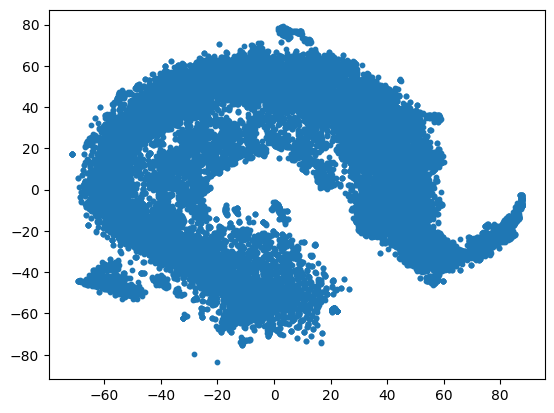

In [8]:
from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0).fit_transform(log2FPKM_df) 

plt.scatter(tsne[:,0], tsne[:,1], s=10)
plt.savefig('tsne.png')

The plot shows that there is one cluster of data, with only one cluster of outliers. The plot doesn't really indicate any meaningful pattern in the data, unfortunately.

I'll try and change the perplexity value and learning rate to see how that affects the plot.

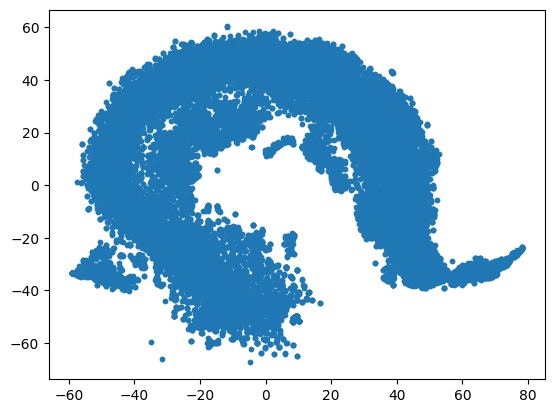

In [9]:
tsne = TSNE(n_components=2,perplexity=50,learning_rate=400, random_state=0).fit_transform(log2FPKM_df) 

plt.scatter(tsne[:,0], tsne[:,1], s=10)
plt.savefig('tsne2.png')

That doesn't seem to have changed the distribution much at all. I'll be moving on to looking at the provided clinical data.

In [10]:
#importing patientInfo.tsv
patientInfo_df = pd.read_csv('patientInfo.tsv', sep='\t')

Let's do our usual sanity checks.

In [11]:
#checking the shape of the clinical data
print(f'patientInfo_df shape: {patientInfo_df.shape}')

patientInfo_df shape: (498, 7)


We can see that the data has 498 samples, as mentioned in the abstract, and 7 columns. Let's look at the head of the data.

In [12]:
patientInfo_df.head

<bound method NDFrame.head of         ID FactorValue..Sex.  FactorValue..age.at.diagnosis.  \
0    NB498            female                             530   
1    NB497            female                             379   
2    NB496              male                             132   
3    NB495              male                             163   
4    NB494              male                              56   
..     ...               ...                             ...   
493  NB005            female                             536   
494  NB004            female                             335   
495  NB003            female                             625   
496  NB002              male                            1808   
497  NB001              male                             987   

     FactorValue..death.from.disease.  FactorValue..high.risk.  \
0                                 NaN                      NaN   
1                                 0.0                      0.0   
2  

Let's print all the columns to look at what the metadata is.

In [13]:
#printing column labels in patientInfo_df
print(patientInfo_df.columns)

Index(['ID', 'FactorValue..Sex.', 'FactorValue..age.at.diagnosis.',
       'FactorValue..death.from.disease.', 'FactorValue..high.risk.',
       'FactorValue..inss.stage.', 'FactorValue..progression.'],
      dtype='object')


We can see that the metadata given to us includes: <br>
- ID
- Sex
- Age at Diagnosis (in days)
- Death
- High Risk
- INSS Stage
- Progression to a tumour

Moving on to the training data...

In [14]:
#importing the patientInfo_train.tsv file
patientInfo_train_df = pd.read_csv('patientInfo_train.tsv', sep='\t')

Let's do our usual sanity checks.

In [15]:
#checking the shape of the data
print(f'patientInfo_train_df shape: {patientInfo_train_df.shape}') 

patientInfo_train_df shape: (249, 7)


In [16]:
#Now, let's inspect the data
patientInfo_train_df.head

<bound method NDFrame.head of         ID FactorValue..Sex.  FactorValue..age.at.diagnosis.  \
0    NB497            female                             379   
1    NB495              male                             163   
2    NB493              male                             190   
3    NB491              male                            2326   
4    NB489            female                             865   
..     ...               ...                             ...   
244  NB009            female                             217   
245  NB007              male                             942   
246  NB005            female                             536   
247  NB003            female                             625   
248  NB001              male                             987   

     FactorValue..death.from.disease.  FactorValue..high.risk.  \
0                                   0                        0   
1                                   0                        0   
2  

Let's now look for any missing values in the data.

In [17]:
#checking for missing values
patientInfo_train_df.isnull().sum()

ID                                  0
FactorValue..Sex.                   0
FactorValue..age.at.diagnosis.      0
FactorValue..death.from.disease.    0
FactorValue..high.risk.             0
FactorValue..inss.stage.            0
FactorValue..progression.           0
dtype: int64

There are no missing values, which is great. It means that I won't have to impute any data. This makes the analysis more robust and accurate.

The names of the columns are complicated, so let's rename them to make them more readable.

In [18]:
# Define the mapping of old column names to new column names
column_mapping = {
    'ID ': 'ID',
    'FactorValue..Sex.': 'Sex',
    'FactorValue..age.at.diagnosis': 'Age',
    'FactorValue..death.from.disease': 'Death',
    'FactorValue..high.risk': 'High Risk',
    'FactorValue..inss.stage': 'INSS',
    'FactorValue..progression': 'Progression'
}

# Rename the columns
patientInfo_train_df = patientInfo_train_df.rename(columns=column_mapping)


In [19]:
print(patientInfo_train_df.columns)

Index(['ID', 'Sex', 'FactorValue..age.at.diagnosis.',
       'FactorValue..death.from.disease.', 'FactorValue..high.risk.',
       'FactorValue..inss.stage.', 'FactorValue..progression.'],
      dtype='object')


Let's now combine the log2FPKM_df and patientInfo_test_df dataframes into a single dataframe.

This new dataframe will be used to build the machine learning models.

In [33]:
#reloading the data
expr = pd.read_csv('log2FPKM.tsv', sep= '\t',index_col=0) 
clinical = pd.read_csv('patientInfo_train.tsv', sep='\t')

# Transpose expression data 
expr = expr.T 

# Reset index to make it a column 
expr = expr.reset_index()
expr = expr.rename(columns={'index':'ID'}) 



The expr dataframe has lots of samples named differently than the clinical dataframe. Let's normalise the labels so that when merged, it does so properly.

In [34]:
#renaming the samples in expression data
expr['ID'] = expr['ID'].str.replace(r'NB(\d+)_.*', r'NB\1', regex=True)

In [36]:
#checking the dataframe to make sure it looks as expected.
expr.head

<bound method NDFrame.head of 00gene_id     ID  1/2-SBSRNA4      A1BG  A1BG-AS1      A1CF     A2LD1  \
0          NB001     0.834381  1.910053  1.453191  0.005102  0.580151   
1          NB002     0.743094  0.941996  0.640614  0.005902  0.738233   
2          NB003     0.909414  1.950857  1.156765  0.005192  0.927667   
3          NB004     0.795775  1.989477  1.525277  0.000000  0.936497   
4          NB005     0.905540  1.942946  1.365043  0.025347  0.924853   
..           ...          ...       ...       ...       ...       ...   
493        NB494     0.491331  1.451425  0.933275  0.004998  0.957837   
494        NB495     0.868249  1.493852  1.208723  0.004853  0.812093   
495        NB496     0.911379  1.641241  0.904511  0.000000  0.488748   
496        NB497     0.660139  1.994978  1.529221  0.022780  1.068072   
497        NB498     1.152988  1.289534  1.102866  0.018720  0.782887   

00gene_id       A2M     A2ML1     A2MP1    A4GALT  ...    ZWILCH     ZWINT  \
0          5.13

In [37]:
# Merge on PatientID  
merged = clinical.merge(expr, on='ID')

Let's look at this data and do our regular sanity checks.

In [38]:
#checking the shape of the merged data
print(f'merged data shape: {merged.shape}')

merged data shape: (249, 23153)
